# Steam Game Clustering with PCA
## Value-for-Money

Dataset Reference: https://www.kaggle.com/datasets/artermiloff/steam-games-dataset/data

This notebook performs unsupervised clustering of Steam games using engineered behavioral features.
We apply PCA for dimensionality reduction and K-Means for clustering, then interpret clusters based on derived gameplay and market behavior metrics.


In [248]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 200)

## Notebook Outline
1. Load and inspect data  
2. Data cleaning
3. EDA
4. Feature engineering  
5. PCA  
6. Clustering + evaluation  
7. Cluster profiling and interpretation  
8. Repeat steps 4–7 for each clustering perspective  


##Data Inspection

In [249]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/datasets/advML/games_march2025.csv')

print("Dataset shape:", df.shape)
df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (89618, 47)


,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,header_image,website,support_url,support_email,windows,mac,linux,metacritic_score,metacritic_url,achievements,recommendations,notes,supported_languages,full_audio_languages,packages,developers,publishers,categories,genres,screenshots,movies,user_score,score_rank,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
0,730,Counter-Strike 2,2012-08-21,0,0.0,1,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...",NaN,https://shared.akamai.steamstatic.com/store_it...,http://counter-strike.net/,NaN,NaN,True,False,True,0,NaN,1,4401572,Includes intense violence and blood.,"['Czech', 'Danish', 'Dutch', 'English', 'Finni...","['English', 'Indonesian']","[{'title': 'Buy Counter-Strike 2', 'descriptio...",['Valve'],['Valve'],"['Multi-player', 'Cross-Platform Multiplayer',...","['Action', 'Free To Play']",['https://shared.akamai.steamstatic.com/store_...,['http://video.akamai.steamstatic.com/store_tr...,0,NaN,7480813,1135108,100000000 - 200000000,33189,879,5174,350,0,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",86,8632939,82,96473
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.0,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,NaN,https://shared.akamai.steamstatic.com/store_it...,https://www.pubg.com,https://support.pubg.com/hc/en-us,NaN,True,False,False,0,NaN,37,1732007,NaN,"['English', 'Korean', 'Simplified Chinese', 'F...",[],[],['PUBG Corporation'],"['KRAFTON, Inc.']","['Multi-player', 'PvP', 'Online PvP', 'Stats',...","['Action', 'Adventure', 'Massively Multiplayer...",['https://shared.akamai.steamstatic.com/store_...,[],0,NaN,1487960,1024436,50000000 - 100000000,0,0,0,0,0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",59,2513842,68,16720
2,570,Dota 2,2013-07-09,0,0.0,2,"The most-played game on Steam. Every day, mill...","The most-played game on Steam. Every day, mill...","Every day, millions of players worldwide enter...",“A modern multiplayer masterpiece.” 9.5/10 – D...,https://shared.akamai.steamstatic.com/store_it...,http://www.dota2.com/,NaN,NaN,True,True,True,90,https://www.metacritic.com/game/pc/dota-2?ftag...,0,14337,"Dota 2 includes fantasy violence, use of alcoh...","['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['English', 'Korean', 'Simplified Chinese', 'V...","[{'title': 'Buy Dota 2', 'description': '', 's...",['Valve'],['Valve'],"['Multi-player', 'Co-op', 'Steam Trading Cards...","['Action', 'Strategy', 'Free To Play']",['https://shared.akamai.steamstatic.com/store_...,['http://video.akamai.steamstatic.com/store_tr...,0,NaN,1998462,451338,200000000 - 500000000,43031,1536,898,892,0,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",81,2452595,80,29366


In [250]:
print("Shape:", df.shape)
df.info()

Shape: (89618, 47)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89618 entries, 0 to 89617
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     89618 non-null  int64  
 1   name                      89618 non-null  object 
 2   release_date              89618 non-null  object 
 3   required_age              89618 non-null  int64  
 4   price                     89618 non-null  float64
 5   dlc_count                 89618 non-null  int64  
 6   detailed_description      89421 non-null  object 
 7   about_the_game            89398 non-null  object 
 8   short_description         89498 non-null  object 
 9   reviews                   10401 non-null  object 
 10  header_image              89618 non-null  object 
 11  website                   41114 non-null  object 
 12  support_url               44110 non-null  object 
 13  support_email             78798 non-null  

In [251]:
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing_pct.head(15)

,0
score_rank,99.956482
metacritic_url,96.042090
reviews,88.394073
notes,81.428954
website,54.123056
support_url,50.779977
support_email,12.073467
about_the_game,0.245486
detailed_description,0.219822
short_description,0.133902


In [252]:
df["price"].describe()

,price
count,89618.000000
mean,7.309623
std,13.331073
min,0.000000
25%,0.990000
50%,4.990000
75%,9.990000
max,999.980000


In [253]:
df["estimated_owners"].head(10)

,estimated_owners
0,100000000 - 200000000
1,50000000 - 100000000
2,200000000 - 500000000
3,50000000 - 100000000
4,20000000 - 50000000
5,20000000 - 50000000
6,20000000 - 50000000
7,20000000 - 50000000
8,20000000 - 50000000
9,50000000 - 100000000


In [254]:
df[["average_playtime_forever", "average_playtime_2weeks"]].describe()

,average_playtime_forever,average_playtime_2weeks
count,8.961800e+04,89618.000000
mean,1.149119e+02,5.032694
std,6.814748e+03,181.100334
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,0.000000e+00,0.000000
75%,0.000000e+00,0.000000
max,1.462997e+06,18568.000000


In [255]:
df_base = data.copy()
print("df_base shape:", df_base.shape)

df_base shape: (8010, 18)


##Data Cleaning

In [256]:
def parse_owner_mid(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace(",", "").strip()
    if "-" in s:
        lo, hi = s.split("-", 1)
        return (float(lo) + float(hi)) / 2
    return np.nan

df["owners_mid"] = df["estimated_owners"].apply(parse_owner_mid)

In [257]:
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")

today = pd.Timestamp.today()
df["release_age_years"] = (today - df["release_date"]).dt.days / 365.25

In [258]:
keep_cols = [
    "appid", "name",
    "price", "discount", "dlc_count",
    "positive", "negative",
    "pct_pos_total", "pct_pos_recent",
    "num_reviews_total", "num_reviews_recent",
    "average_playtime_forever", "average_playtime_2weeks",
    "median_playtime_forever", "median_playtime_2weeks",
    "peak_ccu",
    "owners_mid",
    "release_age_years"
]

data = df[keep_cols].copy()
print("Initial working shape:", data.shape)

Initial working shape: (89618, 18)


Removing games with no owners or no lifetime playtime

In [259]:
data = data.dropna(subset=["owners_mid", "average_playtime_forever"])
data = data[data["owners_mid"] > 0]
data = data[data["average_playtime_forever"] > 0]

print("After playtime & owner filtering:", data.shape)

After playtime & owner filtering: (8010, 18)


In [260]:
data[["owners_mid", "average_playtime_forever", "price"]].describe()

,owners_mid,average_playtime_forever,price
count,8.010000e+03,8.010000e+03,8010.000000
mean,6.195306e+05,1.285665e+03,11.845763
std,5.053384e+06,2.276281e+04,12.389742
min,1.000000e+04,1.000000e+00,0.000000
25%,3.500000e+04,6.400000e+01,1.990000
50%,7.500000e+04,2.180000e+02,8.990000
75%,3.500000e+05,5.110000e+02,18.990000
max,3.500000e+08,1.462997e+06,99.990000


##EDA

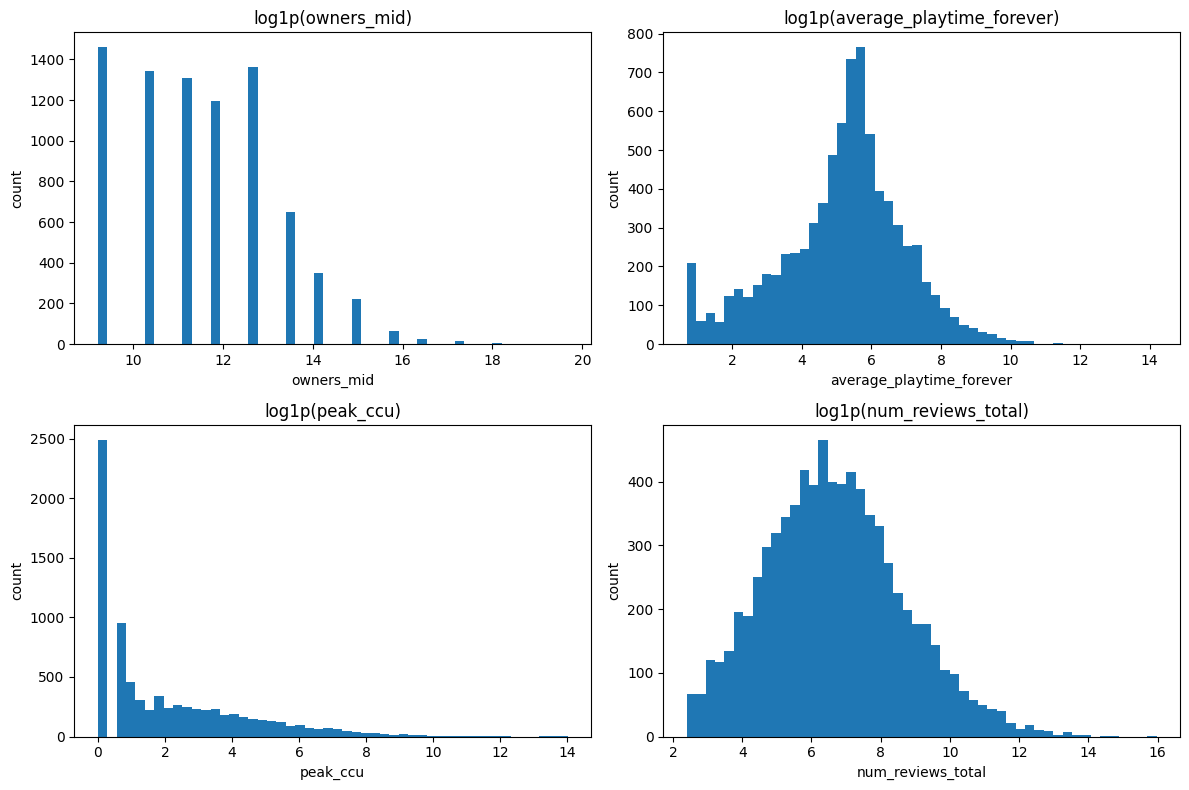

In [261]:
log_cols = [
    "owners_mid",
    "average_playtime_forever",
    "peak_ccu",
    "num_reviews_total"
]

n_cols = 2
n_rows = int(np.ceil(len(log_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for ax, c in zip(axes, log_cols):
    valid = data[c].replace([np.inf, -np.inf], np.nan).dropna()
    valid = valid[valid >= 0]

    ax.hist(np.log1p(valid), bins=50)
    ax.set_title(f"log1p({c})")
    ax.set_xlabel(c)
    ax.set_ylabel("count")

for ax in axes[len(log_cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


**owners_mid**
- The vertical “bars” (spikes) are because estimated_owners is given in ranges, and converting to midpoint creates discrete bins. This is not wrong, it’s just how the dataset is structured.
- Clustering with 'owners' directly could cause the bins to dominate them

**average_playtime_forever**
- One main hump, mild tail. Good for PCA
- Log-transform to avoid being wrecked by extreme tails. Using this to convert to hours then log

**peak_ccu**
- Big spike near 0 after log1p = many games have very low or zero peak CCU. Heavy tail, but still usable.
- peak_ccu still meaningful, but could be a 'popularity shock' type of feature. Can keep for engagement/lifecycle.

**num_reviews_total**
- Looks clean after log-transform. Reviews seems to be a strong behavioral proxy
- Could work really well with reviews_per_owner

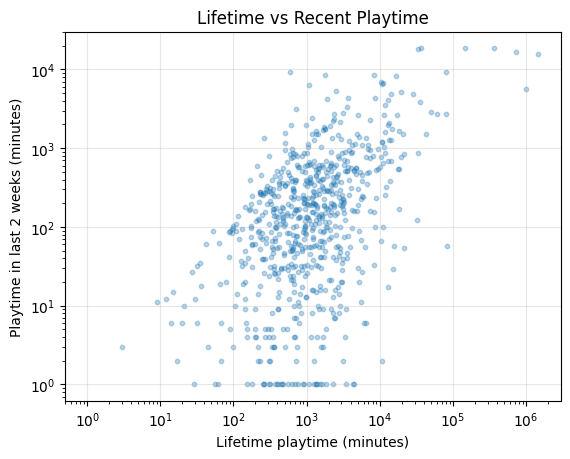

In [262]:
plt.figure()
plt.scatter(
    data["average_playtime_forever"],
    data["average_playtime_2weeks"],
    alpha=0.3,
    s=10
)
plt.xlabel("Lifetime playtime (minutes)")
plt.ylabel("Playtime in last 2 weeks (minutes)")
plt.title("Lifetime vs Recent Playtime")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.show()

- Points below diagonal can be classified as **declining games**
- Points near the diagonal are games with **stable engagement**
- Points above can either be or both **resurgent** and **volatile games**
##
######Declining - high lifetime but low recent
######Stable - recent playtime stays relatively consistent compared to lifetime
######Spiking/volatile - low/moderate lifetime but unusually high recent

- This can justify our "**Stability vs Volatility**" clustering

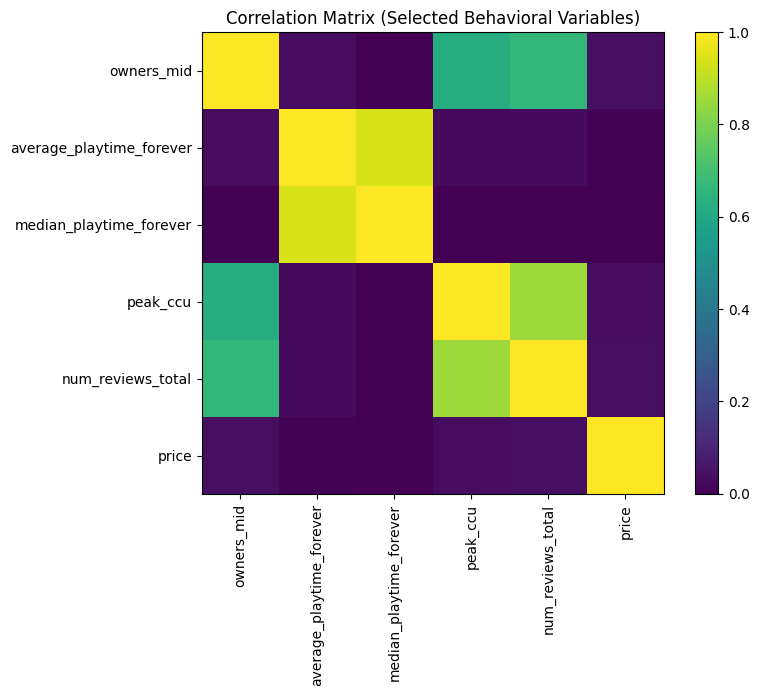

In [263]:
corr_cols = [
    "owners_mid",
    "average_playtime_forever",
    "median_playtime_forever",
    "peak_ccu",
    "num_reviews_total",
    "price"
]

corr = data[corr_cols].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr)
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar()
plt.title("Correlation Matrix (Selected Behavioral Variables)")
plt.show()

**Key relationships visible:**

- average_playtime_forever ↔ median_playtime_forever is very strong (basically redundant)
- peak_ccu ↔ num_reviews_total looks strong
- owners_mid ↔ num_reviews_total is moderate-strong
- price is weakly correlated with almost everything (good — it acts independently)


Many variables are correlated and redundant, so PCA makes sense

For clustering, avoiding to feed both mean and median in raw form to PCA, then just use one of them + a retention proxy like 'median/mean'

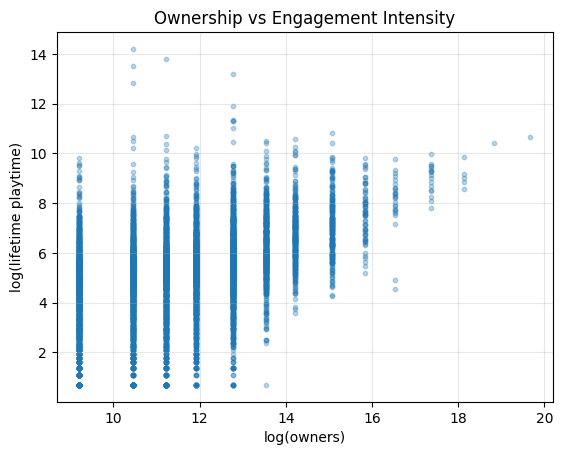

In [264]:
plt.figure()
plt.scatter(
    np.log1p(data["owners_mid"]),
    np.log1p(data["average_playtime_forever"]),
    s=10,
    alpha=0.3
)
plt.xlabel("log(owners)")
plt.ylabel("log(lifetime playtime)")
plt.title("Ownership vs Engagement Intensity")
plt.grid(True, alpha=0.3)
plt.show()

- high owners but low playtime points (mass-market shallow)
- lower owners with higher playtime points (niche deep)
- The vertical stripes again come from owner bins (ranges → midpoint)

**Justifies that our engagement cluster idea might be viable.**

##Engagement Profiles Feature Engineering

In [265]:
fe = data.copy()

#fix invalid review counts first(some datasets use -1 for missing)
fe["num_reviews_total_clean"]  = fe["num_reviews_total"].clip(lower=0)
fe["num_reviews_recent_clean"] = fe["num_reviews_recent"].clip(lower=0)

#fix invalid peak_ccu just in case(should already be non-negative)
fe["peak_ccu_clean"] = fe["peak_ccu"].clip(lower=0)

#logs(heavy-tailed)
fe["log_owners"] = np.log1p(fe["owners_mid"])
fe["log_playtime_forever"] = np.log1p(fe["average_playtime_forever"])
fe["log_reviews_total"] = np.log1p(fe["num_reviews_total_clean"])
fe["log_peak_ccu"] = np.log1p(fe["peak_ccu_clean"])

#per-owner intensity(avoid owner-bin artifacts)
fe["playtime_per_owner"] = fe["average_playtime_forever"] / (fe["owners_mid"] + 1)
fe["reviews_per_owner"]  = fe["num_reviews_total_clean"] / (fe["owners_mid"] + 1)

#retention proxy
fe["retention_proxy"] = fe["median_playtime_forever"] / (fe["average_playtime_forever"] + 1)

#stability / volatility ratios(with +1 smoothing)
fe["recent_play_ratio"] = (fe["average_playtime_2weeks"] + 1) / (fe["average_playtime_forever"] + 1)
fe["recent_median_ratio"] = (fe["median_playtime_2weeks"] + 1) / (fe["median_playtime_forever"] + 1)

fe["recent_review_ratio"] = (fe["num_reviews_recent_clean"] + 1) / (fe["num_reviews_total_clean"] + 1)

#sentiment features
fe["pos_ratio_counts"] = fe["positive"] / (fe["positive"] + fe["negative"] + 1)
fe["sentiment_shift"]  = (fe["pct_pos_recent"] - fe["pct_pos_total"]) / 100.0


In [266]:
check_cols = [
    "log_owners","log_playtime_forever","log_reviews_total","log_peak_ccu",
    "playtime_per_owner","reviews_per_owner","retention_proxy",
    "recent_play_ratio","recent_median_ratio","recent_review_ratio",
    "sentiment_shift","pos_ratio_counts"
]
fe[check_cols].describe()


,log_owners,log_playtime_forever,log_reviews_total,log_peak_ccu,playtime_per_owner,reviews_per_owner,retention_proxy,recent_play_ratio,recent_median_ratio,recent_review_ratio,sentiment_shift,pos_ratio_counts
count,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8.010000e+03,8010.000000,8010.000000,8010.000000
mean,11.594613,5.160812,6.469430,2.081825,0.020726,0.017450,0.985889,0.064333,2.521538e-01,0.564907,-0.470814,0.759028
std,1.673583,1.811141,2.275839,2.270131,0.557045,0.164325,0.378110,0.269819,4.749844e+00,33.495500,0.389053,0.195094
min,9.210440,0.693147,0.000000,0.000000,0.000001,0.000000,0.000648,0.000002,9.374953e-07,0.000011,-1.010000,0.000000
25%,10.463132,4.174387,5.117994,0.000000,0.000447,0.003183,0.857143,0.002660,2.824859e-03,0.002326,-0.820000,0.684086
50%,11.225257,5.389072,6.481576,1.386294,0.001520,0.007803,0.995062,0.005952,6.024096e-03,0.006623,-0.630000,0.808164
75%,12.765691,6.238325,7.878818,3.367296,0.005256,0.015684,1.137069,0.028214,3.030303e-02,0.016262,-0.030000,0.895277
max,19.673444,14.195998,15.971096,14.008077,41.798720,10.291271,1.999941,15.506757,2.411558e+02,2970.000000,1.010000,0.995868


In [267]:
bad = {}
for c in check_cols:
    s = fe[c].replace([np.inf, -np.inf], np.nan)
    bad[c] = {
        "nan": int(s.isna().sum()),
        "neg": int((s.dropna() < 0).sum()),
        "inf": int(np.isinf(fe[c]).sum())
    }
bad


{'log_owners': {'nan': 0, 'neg': 0, 'inf': 0},
 'log_playtime_forever': {'nan': 0, 'neg': 0, 'inf': 0},
 'log_reviews_total': {'nan': 0, 'neg': 0, 'inf': 0},
 'log_peak_ccu': {'nan': 0, 'neg': 0, 'inf': 0},
 'playtime_per_owner': {'nan': 0, 'neg': 0, 'inf': 0},
 'reviews_per_owner': {'nan': 0, 'neg': 0, 'inf': 0},
 'retention_proxy': {'nan': 0, 'neg': 0, 'inf': 0},
 'recent_play_ratio': {'nan': 0, 'neg': 0, 'inf': 0},
 'recent_median_ratio': {'nan': 0, 'neg': 0, 'inf': 0},
 'recent_review_ratio': {'nan': 0, 'neg': 0, 'inf': 0},
 'sentiment_shift': {'nan': 0, 'neg': 6478, 'inf': 0},
 'pos_ratio_counts': {'nan': 0, 'neg': 0, 'inf': 0}}

- No NaNs
- No infinities
- No invalid negatives
- Only sentiment_shift has negatives which is expected and meaningful

All engineered features were verified to be finite and free of invalid values prior to dimensionality reduction.

In [268]:
engagement_features = [
    "log_owners",
    "log_playtime_forever",
    "log_reviews_total",
    "log_peak_ccu",
    "playtime_per_owner",
    "reviews_per_owner",
    "retention_proxy",
    "pos_ratio_counts"
]

X_eng = fe[engagement_features].copy()
X_eng.shape

(8010, 8)

In [269]:
from sklearn.preprocessing import StandardScaler

X_eng = fe[engagement_features].copy()

scaler = StandardScaler()
X_eng_scaled = scaler.fit_transform(X_eng)

##Engagement Profiles PCA

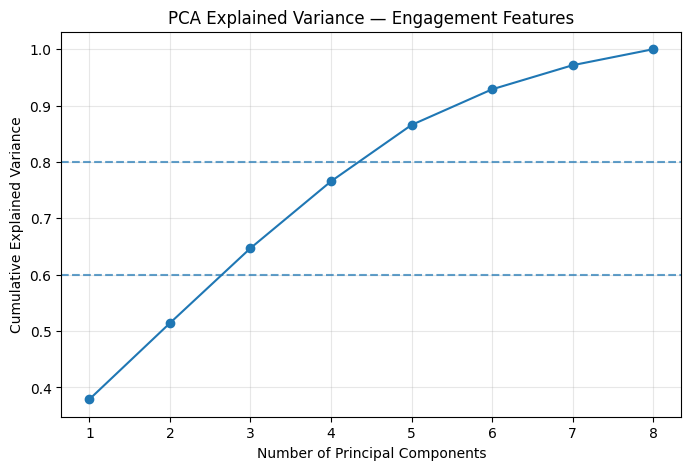

In [270]:
pca_full = PCA(random_state=42)
Xp_full = pca_full.fit_transform(X_eng_scaled)
explained = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.axhline(0.6, linestyle='--', alpha=0.7)
plt.axhline(0.8, linestyle='--', alpha=0.7)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance — Engagement Features")
plt.grid(True, alpha=0.3)
plt.show()

In [271]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
X_eng_pca = pca.fit_transform(X_eng_scaled)

print("PCA shape:", X_eng_pca.shape)
print("Explained variance:", pca.explained_variance_ratio_.sum())

PCA shape: (8010, 3)
Explained variance: 0.6470559871235348


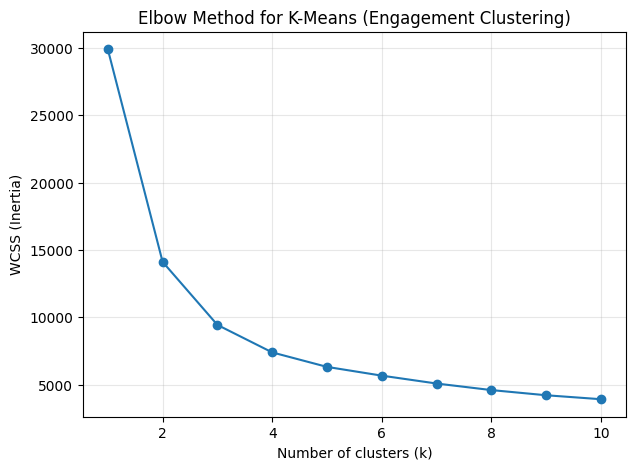

In [272]:
plt.figure(figsize=(7,5))
plt.plot(k_range, wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for K-Means (Engagement Clustering)")
plt.grid(True, alpha=0.3)
plt.show()

In [273]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
X_eng_pca = pca.fit_transform(X_eng_scaled)

print("PCA shape:", X_eng_pca.shape)
print("Explained variance:", pca.explained_variance_ratio_.sum())

PCA shape: (8010, 3)
Explained variance: 0.6470559871235348


In [274]:
# Convert PCA to DataFrame (POSITIONAL, clean)
pca_df = pd.DataFrame(X_eng_pca, columns=[f"PC{i+1}" for i in range(3)])

# Z-score in PCA space
z = (pca_df - pca_df.mean()) / pca_df.std()
outlier_mask = (np.abs(z) > 5).any(axis=1)

print("Outliers detected:", outlier_mask.sum())

Outliers detected: 16


In [275]:
mask = np.asarray(outlier_mask, dtype=bool)

keep_pos = np.where(~mask)[0]   # positions to keep

X_eng_pca_clean = X_eng_pca[keep_pos]
fe_clean = fe.iloc[keep_pos].copy()

print("Outliers detected:", mask.sum())
print("Original:", fe.shape[0])
print("After outlier removal:", fe_clean.shape[0])

Outliers detected: 16
Original: 8010
After outlier removal: 7994


In [276]:
print("Mask length:", len(mask))
print("X_eng_pca rows:", X_eng_pca.shape[0])
print("fe rows:", fe.shape[0])

Mask length: 8010
X_eng_pca rows: 8010
fe rows: 8010


##Engagement Profiles K-Means Clustering

In [277]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_eng_pca_clean)

fe_clean["engagement_cluster"] = labels

In [278]:
fe_clean["engagement_cluster"].value_counts()

,count
engagement_cluster,
3,3230
1,2243
0,1515
2,1006


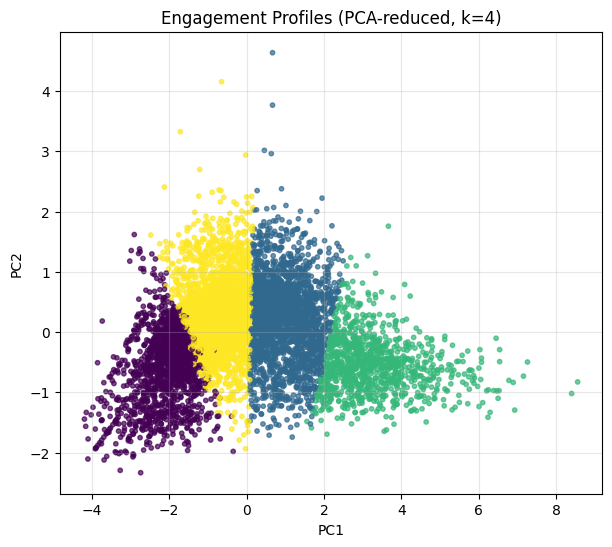

In [279]:
plt.figure(figsize=(7,6))
plt.scatter(
    X_eng_pca_clean[:, 0],
    X_eng_pca_clean[:, 1],
    c=fe_clean["engagement_cluster"],
    s=10,
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Engagement Profiles (PCA-reduced, k=4)")
plt.grid(True, alpha=0.3)
plt.show()

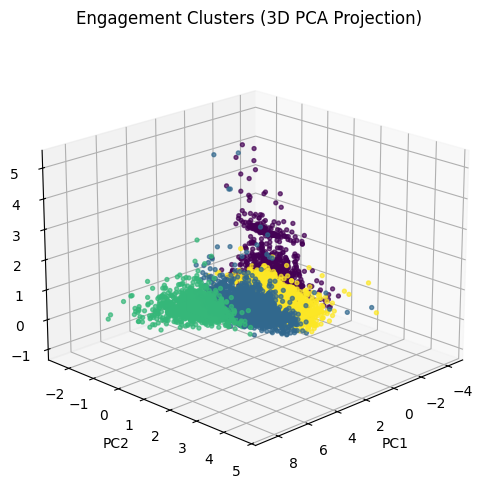

In [280]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_eng_pca_clean[:, 0],  # PC1
    X_eng_pca_clean[:, 1],  # PC2
    X_eng_pca_clean[:, 2],  # PC3
    c=fe_clean["engagement_cluster"],
    s=8,
    alpha=0.7
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Engagement Clusters (3D PCA Projection)")

ax.view_init(elev=20, azim=45)

plt.show()

##Engagement Profiles Hierarchical Clustering
mainly for validation

In [281]:
X_hier = X_eng_pca_clean

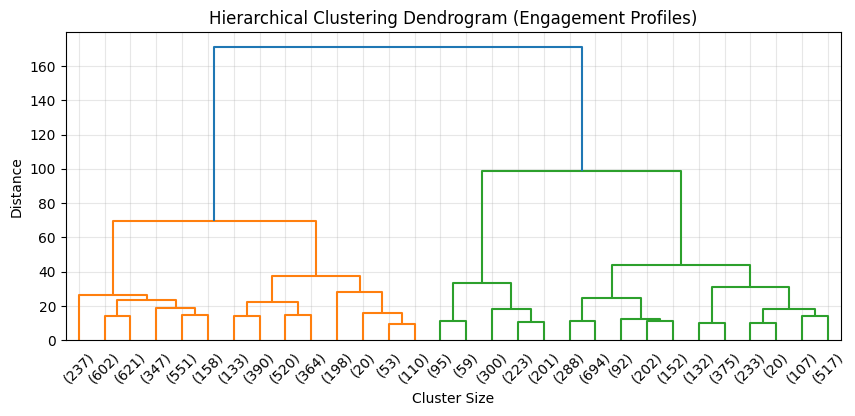

In [282]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X_hier, method="ward")

plt.figure(figsize=(10, 4))
dendrogram(
    Z,
    truncate_mode="lastp",
    p=30,
    leaf_rotation=45,
    leaf_font_size=10,
)
plt.title("Hierarchical Clustering Dendrogram (Engagement Profiles)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.grid(alpha=0.3)
plt.show()

In [283]:
from sklearn.cluster import AgglomerativeClustering

hier = AgglomerativeClustering(
    n_clusters=4,
    linkage="ward"
)

hier_labels = hier.fit_predict(X_hier)

fe_clean["hier_cluster"] = hier_labels
fe_clean["hier_cluster"].value_counts()

,count
hier_cluster,
0,2812
3,2516
1,1788
2,878


In [284]:
pd.crosstab(
    fe_clean["engagement_cluster"],
    fe_clean["hier_cluster"],
    rownames=["KMeans"],
    colnames=["Hierarchical"]
)

Hierarchical,0,1,2,3
KMeans,,,,
0,7,1431,0,77
1,2208,4,2,29
2,130,0,876,0
3,467,353,0,2410


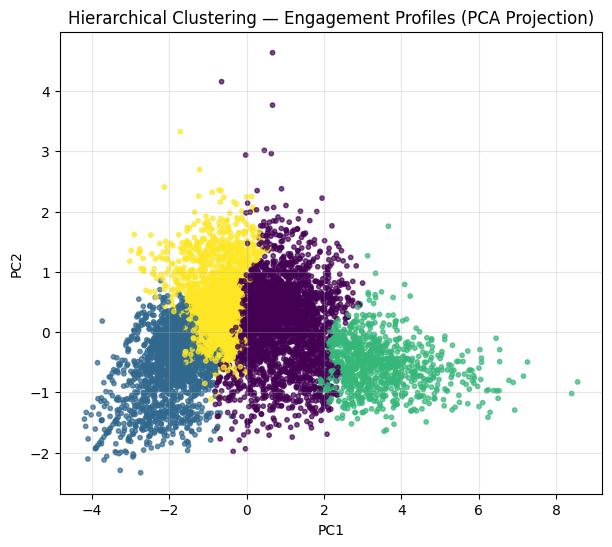

In [285]:
plt.figure(figsize=(7,6))
plt.scatter(
    X_hier[:, 0],
    X_hier[:, 1],
    c=fe_clean["hier_cluster"],
    s=10,
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Hierarchical Clustering — Engagement Profiles (PCA Projection)")
plt.grid(alpha=0.3)
plt.show()

##Cluser Interpretation and Evaluation

KMeans(0) = Hier(1)

KMeans(1) = Hier(0)

KMeans(2) = Hier(2)

KMeans(3) = Hier(0), Hier(1)

Normal because:

KMeans forces “closest centroid” partitions

Hierarchical (Ward) merges based on minimum increase in within-cluster variance

So border points move around

**The engagement structure is stable, but cluster boundaries are not perfectly sharp.**

In [286]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(fe_clean["engagement_cluster"], fe_clean["hier_cluster"])
nmi = normalized_mutual_info_score(fe_clean["engagement_cluster"], fe_clean["hier_cluster"])

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): 0.6480536601068269
Normalized Mutual Information (NMI): 0.6847369031576301


In [287]:
fe_clean.columns[fe_clean.columns.str.contains("cluster", case=False)]

Index(['engagement_cluster', 'hier_cluster'], dtype='object')

**K-Means and Hierarchical clustering:**

Used different assumptions and optimized different objective functions, yet they discovered very similar engagement structures.

The engagement profiles are intrinsic to the data, not an artifact of a specific algorithm

Agreement between K-Means and hierarchical clustering was evaluated using the Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI). The obtained ARI value of 0.65 and NMI value of 0.68 indicate substantial agreement between the two clustering methods. This suggests that the identified engagement profiles are stable and not dependent on a specific clustering assumption.


In [288]:
owners_med = prof["owners_mid"].median()
play_med   = prof["average_playtime_forever"].median()
recent_med = prof["recent_play_ratio"].median()

def name_cluster(row):
    high_owners = row["owners_mid"] >= owners_med
    high_play   = row["average_playtime_forever"] >= play_med
    high_recent = row["recent_play_ratio"] >= recent_med

    if high_owners and high_play:
        return "Mass-market, long-play"
    if high_owners and not high_play:
        return "Mass-market, short-play"
    if (not high_owners) and high_recent:
        return "Niche, recently active"
    return "Niche, low-engagement"

cluster_name_map = {c: name_cluster(prof.loc[c]) for c in prof.index}
cluster_name_map

{0: 'Niche, recently active',
 1: 'Mass-market, long-play',
 2: 'Mass-market, long-play',
 3: 'Niche, recently active'}

In [289]:
fe_clean["engagement_cluster_name"] = fe_clean["engagement_cluster"].map(cluster_name_map)
fe_clean["engagement_cluster_name"].value_counts()

,count
engagement_cluster_name,
"Niche, recently active",4745
"Mass-market, long-play",3249


In [290]:
print(X_eng_pca_clean.shape[0], fe_clean.shape[0])

7994 7994


**We attempted to cluster engagement profiles, and through this process we discovered that the available features are insufficient to fully separate intuitive engagement archetypes.**

While engagement-based clustering revealed consistent high-level behavioral regimes, the results suggest that the dataset lacks sufficient granularity to distinguish certain intuitive engagement archetypes, such as niche low-engagement or mass-market short-play games. This indicates that aggregate playtime and ownership metrics may be insufficient proxies for intended gameplay depth, and that the engagement clustering serves primarily as an exploratory analysis of behavioral constraints within the dataset.

##Value-for-Money Feature Engineering

In [291]:
df_base = data.copy()
print("df_base shape:", df_base.shape)
df_base.head(2)

df_base shape: (8010, 18)


,appid,name,price,discount,dlc_count,positive,negative,pct_pos_total,pct_pos_recent,num_reviews_total,num_reviews_recent,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,peak_ccu,owners_mid,release_age_years
0,730,Counter-Strike 2,0.0,0,1,7480813,1135108,86,82,8632939,96473,33189,879,5174,350,1212356,150000000.0,13.448323
2,570,Dota 2,0.0,0,2,1998462,451338,81,80,2452595,29366,43031,1536,898,892,555977,350000000.0,12.566735


In [292]:
df_value = df_base[df_base["price"] > 0].copy() #Drop free games
print("df_value shape:", df_value.shape)
df_value["price"].describe()

df_value shape: (6970, 18)


,price
count,6970.000000
mean,13.613280
std,12.342956
min,0.490000
25%,4.990000
50%,9.990000
75%,19.990000
max,99.990000


In [293]:
df_value["pos_ratio_counts"] = df_value["positive"] / (df_value["positive"] + df_value["negative"] + 1)

In [294]:
df_value["avg_hours"] = df_value["average_playtime_forever"] / 60.0
df_value["med_hours"] = df_value["median_playtime_forever"] / 60.0

In [295]:
df_value["num_reviews_total_clean"] = df_value["num_reviews_total"].clip(lower=0)

In [296]:
df_value["hours_per_price"] = df_value["avg_hours"] / (df_value["price"] + 1)
df_value["median_hours_per_price"] = df_value["med_hours"] / (df_value["price"] + 1)

df_value["reviews_per_price"] = df_value["num_reviews_total_clean"] / (df_value["price"] + 1)
df_value["log_reviews_total"] = np.log1p(df_value["num_reviews_total_clean"])

In [297]:
value_features = [
    "price",
    "hours_per_price",
    "median_hours_per_price",
    "reviews_per_price",
    "pos_ratio_counts",
    "log_reviews_total"
]

In [298]:
bad = {}
for c in value_features:
    s = df_value[c].replace([np.inf, -np.inf], np.nan)
    bad[c] = {
        "nan": int(s.isna().sum()),
        "neg": int((s.dropna() < 0).sum()),
        "inf": int(np.isinf(df_value[c]).sum())
    }
bad

{'price': {'nan': 0, 'neg': 0, 'inf': 0},
 'hours_per_price': {'nan': 0, 'neg': 0, 'inf': 0},
 'median_hours_per_price': {'nan': 0, 'neg': 0, 'inf': 0},
 'reviews_per_price': {'nan': 0, 'neg': 0, 'inf': 0},
 'pos_ratio_counts': {'nan': 0, 'neg': 0, 'inf': 0},
 'log_reviews_total': {'nan': 0, 'neg': 0, 'inf': 0}}

In [299]:
df_value[value_features].describe()

,price,hours_per_price,median_hours_per_price,reviews_per_price,pos_ratio_counts,log_reviews_total
count,6970.000000,6970.000000,6970.000000,6970.000000,6970.000000,6970.000000
mean,13.613280,3.384515,4.197361,490.265855,0.763080,6.468830
std,12.342956,83.672898,137.075935,3819.814841,0.197842,2.221404
min,0.490000,0.000463,0.000463,0.000000,0.000000,0.000000
25%,4.990000,0.127163,0.121008,19.031720,0.693405,5.129899
50%,9.990000,0.385199,0.356656,64.544416,0.815208,6.451260
75%,19.990000,0.942188,0.891406,220.230912,0.900000,7.852731
max,99.990000,4467.688442,8933.592965,234072.144289,0.995868,13.970821


##PCA, Scaling, Scree

In [300]:
from sklearn.preprocessing import StandardScaler

X_value = df_value[value_features].copy()

scaler = StandardScaler()
X_value_scaled = scaler.fit_transform(X_value)

In [301]:
X_value_scaled.mean(axis=0), X_value_scaled.std(axis=0)

(array([-9.78652835e-17, -4.07772015e-18, -3.05829011e-18,  0.00000000e+00,
        -3.26217612e-16,  0.00000000e+00]),
 array([1., 1., 1., 1., 1., 1.]))

In [302]:
from sklearn.decomposition import PCA

pca = PCA()
X_value_pca = pca.fit_transform(X_value_scaled)

explained_var = pca.explained_variance_ratio_
explained_var

array([0.32421734, 0.2814543 , 0.16738763, 0.13887517, 0.07861118,
       0.00945438])

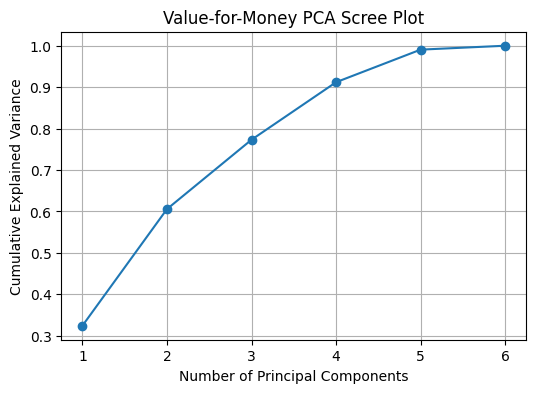

In [303]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
plt.plot(
    range(1, len(explained_var)+1),
    np.cumsum(explained_var),
    marker="o"
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Value-for-Money PCA Scree Plot")
plt.grid(True)
plt.show()

In [304]:
pca_value = PCA(n_components=3)
X_value_pca = pca_value.fit_transform(X_value_scaled)

print("Explained variance:", pca_value.explained_variance_ratio_)
print("Total explained:", pca_value.explained_variance_ratio_.sum())

Explained variance: [0.32421734 0.2814543  0.16738763]
Total explained: 0.7730592748707623


In [305]:
pc_loadings = pd.DataFrame(
    pca_value.components_,
    columns=value_features,
    index=["PC1", "PC2", "PC3"]
)

pc_loadings

,price,hours_per_price,median_hours_per_price,reviews_per_price,pos_ratio_counts,log_reviews_total
PC1,-0.057502,0.704998,0.705129,-0.004563,-0.028174,-0.040611
PC2,0.480188,0.052140,0.046798,0.282011,0.504169,0.656349
PC3,-0.479184,-0.010434,-0.024016,0.874565,-0.064202,0.026661


**PC1** — Playtime Value Density
- hours_per_price        +0.705
- median_hours_per_price +0.705

= How much playable content you get for your money.

- High PC1 → insane hours per peso
- Low PC1 → low content density

**PC2** — Market Confidence / Perceived Quality
- log_reviews_total +0.656
- pos_ratio_counts  +0.504
- price             +0.480


= How confident players are that the game is worth buying.

- High PC2 → expensive but trusted & reviewed
- Low PC2 → cheap, obscure, or risky buys


**PC3** — Engagement-Intensity Premium
- reviews_per_price +0.875
- price             -0.479

= How much attention a game gets relative to its price.

- High PC3 → cheap games with huge engagement
- Low PC3 → expensive games with low crowd pull


*The first principal component captures content value density, emphasizing playtime relative to price. The second component reflects market confidence, driven by review volume, sentiment, and pricing. The third component highlights engagement intensity per cost, distinguishing low-cost high-engagement titles from higher-priced low-visibility games.*

##Value-for-Money K-Means Clustering

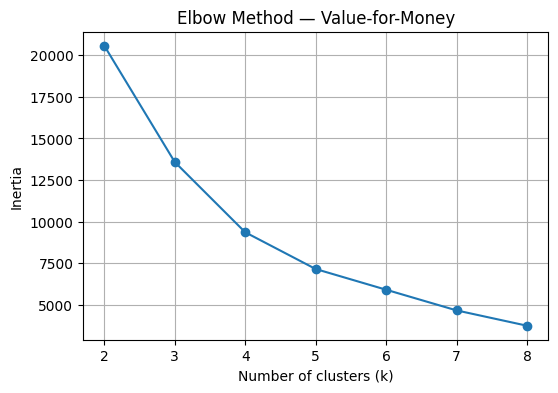

In [306]:
inertias = []
ks = range(2, 9)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_value_pca)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method — Value-for-Money")
plt.grid(True)
plt.show()

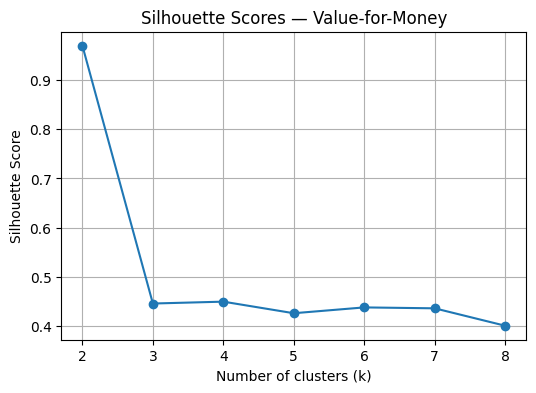

[(2, np.float64(0.9693019481116019)),
 (3, np.float64(0.44631301184754074)),
 (4, np.float64(0.450119410936504)),
 (5, np.float64(0.42663269884549865)),
 (6, np.float64(0.43844056039422324)),
 (7, np.float64(0.4365888985488809)),
 (8, np.float64(0.4012887668076108))]

In [307]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in ks:
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_value_pca)
    sil_scores.append(silhouette_score(X_value_pca, labels))

plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores — Value-for-Money")
plt.grid(True)
plt.show()

list(zip(ks, sil_scores))

In [308]:
kmeans_value = KMeans(n_clusters=4, random_state=42, n_init=10)
df_value["value_cluster"] = kmeans_value.fit_predict(X_value_pca)

df_value["value_cluster"].value_counts()

,count
value_cluster,
0,3710
3,3254
1,4
2,2


In [309]:
df_value.groupby("value_cluster")[value_features].median()

,price,hours_per_price,median_hours_per_price,reviews_per_price,pos_ratio_counts,log_reviews_total
value_cluster,,,,,,
0,17.99,0.387611,0.326682,143.251390,0.880161,7.698709
1,3.54,3305.607249,4410.494924,119.019387,0.813863,6.016350
2,4.99,36.819249,5.463223,187494.584305,0.904285,13.885615
3,4.99,0.381548,0.402010,24.800165,0.709651,5.084500


In [310]:
df_value.groupby("value_cluster")[value_features].mean()

,price,hours_per_price,median_hours_per_price,reviews_per_price,pos_ratio_counts,log_reviews_total
value_cluster,,,,,,
0,19.622752,1.807794,0.968107,749.775456,0.858132,7.880668
1,3.152500,3193.091566,5285.276390,137.410933,0.780541,5.998394
2,4.990000,36.819249,5.463223,187494.584305,0.904285,13.885615
3,6.779828,1.240673,1.386569,79.885450,0.654600,4.855163


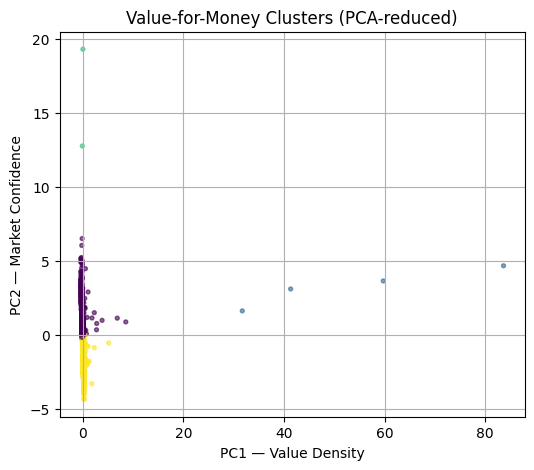

In [311]:
plt.figure(figsize=(6,5))
plt.scatter(
    X_value_pca[:,0],
    X_value_pca[:,1],
    c=df_value["value_cluster"],
    s=8,
    alpha=0.6
)
plt.xlabel("PC1 — Value Density")
plt.ylabel("PC2 — Market Confidence")
plt.title("Value-for-Money Clusters (PCA-reduced)")
plt.grid(True)
plt.show()

yikes.

###2nd Dataframe

In [321]:
df_base = data.copy()
df_value2 = df_base[df_base["price"] > 0].copy()
print("df_value2 shape:", df_value2.shape)
print("df_base shape:", df_base.shape)

df_value2 shape: (6970, 18)
df_base shape: (8010, 18)


##Value-for-Money Feature Engineering 2

In [313]:
needed_cols = [
    "price", "discount", "dlc_count", "achievements", "metacritic_score",
    "positive", "negative", "num_reviews_total",
    "average_playtime_forever", "median_playtime_forever"
]

df_base = df[[c for c in needed_cols if c in df.columns]].copy()
print("df_base shape:", df_base.shape)

df_base shape: (89618, 10)


In [314]:
df_value2 = df_base[df_base["price"] > 0].copy()

In [315]:
print(df_base.columns.tolist())

['price', 'discount', 'dlc_count', 'achievements', 'metacritic_score', 'positive', 'negative', 'num_reviews_total', 'average_playtime_forever', 'median_playtime_forever']


In [318]:
bad = {}
for c in value2_features:
    s = df_value2[c].replace([np.inf, -np.inf], np.nan)
    bad[c] = {"nan": int(s.isna().sum()), "neg": int((s.dropna() < 0).sum()), "inf": int(np.isinf(df_value2[c]).sum())}

print("rows:", df_value2.shape[0])
bad

rows: 75458


{'log_price': {'nan': 0, 'neg': 0, 'inf': 0},
 'hours_per_price': {'nan': 0, 'neg': 0, 'inf': 0},
 'median_hours_per_price': {'nan': 0, 'neg': 0, 'inf': 0},
 'reviews_per_price': {'nan': 0, 'neg': 0, 'inf': 0},
 'pos_ratio_counts': {'nan': 0, 'neg': 0, 'inf': 0},
 'review_volume_log': {'nan': 0, 'neg': 0, 'inf': 0},
 'dlc_log': {'nan': 0, 'neg': 0, 'inf': 0},
 'achievements_log': {'nan': 0, 'neg': 0, 'inf': 0},
 'metacritic_score_imp': {'nan': 0, 'neg': 0, 'inf': 0},
 'meta_has': {'nan': 0, 'neg': 0, 'inf': 0}}

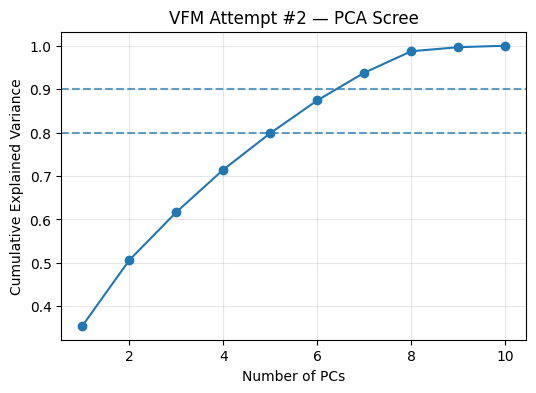

array([0.35529434, 0.50646637, 0.61691501, 0.71466068, 0.79861005,
       0.87407566, 0.93776403, 0.98724159, 0.99658984, 1.        ])

In [319]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_value2[value2_features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_full = PCA(random_state=42)
Xp_full = pca_full.fit_transform(X_scaled)

cum = np.cumsum(pca_full.explained_variance_ratio_)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cum)+1), cum, marker="o")
plt.axhline(0.8, linestyle="--", alpha=0.7)
plt.axhline(0.9, linestyle="--", alpha=0.7)
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Explained Variance")
plt.title("VFM Attempt #2 — PCA Scree")
plt.grid(True, alpha=0.3)
plt.show()

cum

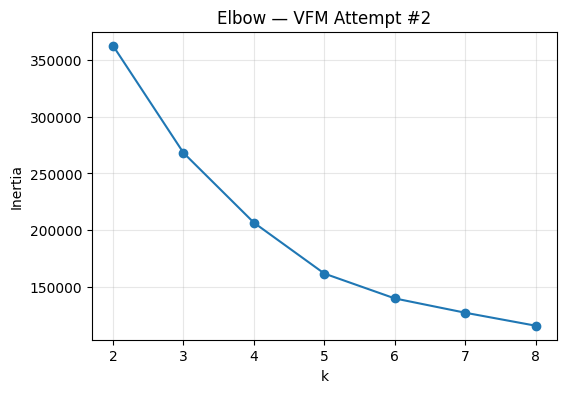

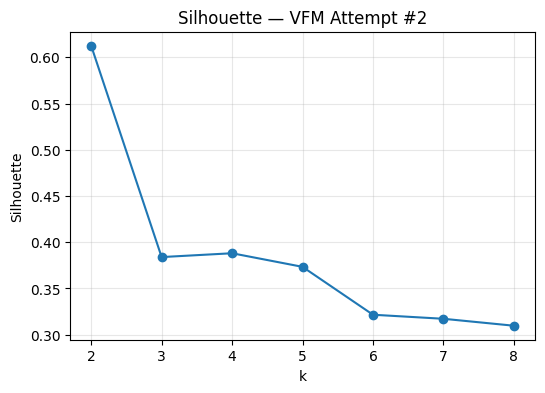

[(2, np.float64(0.6124902752314854)),
 (3, np.float64(0.3839136583394963)),
 (4, np.float64(0.38805118540360317)),
 (5, np.float64(0.3733462942307219)),
 (6, np.float64(0.32155370353191026)),
 (7, np.float64(0.31717472121169793)),
 (8, np.float64(0.3096699739318248))]

In [320]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_components = 4
pca = PCA(n_components=n_components, random_state=42)
Xp = pca.fit_transform(X_scaled)

ks = range(2, 9)
inertias, sils = [], []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xp)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(Xp, labels))

plt.figure(figsize=(6,4))
plt.plot(list(ks), inertias, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.title("Elbow — VFM Attempt #2")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(list(ks), sils, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.title("Silhouette — VFM Attempt #2")
plt.grid(True, alpha=0.3)
plt.show()

list(zip(ks, sils))

In [323]:
print("df_value2 rows:", df_value2.shape[0])
print("Xp rows:", Xp.shape[0])

df_value2 rows: 6970
Xp rows: 75458


In [326]:
import numpy as np

# 1) rebuild a clean base for VFM (independent from engagement)
base_cols = [
    "price", "discount",
    "dlc_count", "achievements", "metacritic_score",
    "positive", "negative", "num_reviews_total",
    "average_playtime_forever", "median_playtime_forever"
]
df_base = df[base_cols].copy()

# 2) paid-only dataset for value-for-money
df_value2 = df_base[df_base["price"] > 0].copy()
print("df_value2 shape:", df_value2.shape)

# 3) core transformations
df_value2["log_price"] = np.log1p(df_value2["price"])

df_value2["avg_hours"] = df_value2["average_playtime_forever"] / 60.0
df_value2["med_hours"] = df_value2["median_playtime_forever"] / 60.0

df_value2["num_reviews_total_clean"] = df_value2["num_reviews_total"].clip(lower=0)

df_value2["review_volume"] = (df_value2["positive"] + df_value2["negative"]).clip(lower=0)
df_value2["review_volume_log"] = np.log1p(df_value2["review_volume"])
df_value2["pos_ratio_counts"] = df_value2["positive"] / (df_value2["positive"] + df_value2["negative"] + 1)

df_value2["dlc_log"] = np.log1p(df_value2["dlc_count"].clip(lower=0))
df_value2["achievements_log"] = np.log1p(df_value2["achievements"].clip(lower=0))

# 4) metacritic: missing flag + impute
df_value2["meta_has"] = (df_value2["metacritic_score"] > 0).astype(int)
df_value2["metacritic_score_imp"] = df_value2["metacritic_score"].replace(0, np.nan)
df_value2["metacritic_score_imp"] = df_value2["metacritic_score_imp"].fillna(
    df_value2.loc[df_value2["metacritic_score_imp"].notna(), "metacritic_score_imp"].median()
)

# 5) value ratios (winsorize + log1p)
df_value2["hours_per_price_raw"] = df_value2["avg_hours"] / (df_value2["price"] + 1)
df_value2["median_hours_per_price_raw"] = df_value2["med_hours"] / (df_value2["price"] + 1)
df_value2["reviews_per_price_raw"] = df_value2["num_reviews_total_clean"] / (df_value2["price"] + 1)

for c in ["hours_per_price_raw", "median_hours_per_price_raw", "reviews_per_price_raw",
          "dlc_log", "achievements_log"]:
    cap = df_value2[c].quantile(0.99)
    df_value2[c] = df_value2[c].clip(upper=cap)

df_value2["hours_per_price"] = np.log1p(df_value2["hours_per_price_raw"])
df_value2["median_hours_per_price"] = np.log1p(df_value2["median_hours_per_price_raw"])
df_value2["reviews_per_price"] = np.log1p(df_value2["reviews_per_price_raw"])

# 6) final feature list (these columns now definitely exist)
value2_features = [
    "log_price",
    "hours_per_price",
    "median_hours_per_price",
    "reviews_per_price",
    "pos_ratio_counts",
    "review_volume_log",
    "dlc_log",
    "achievements_log",
    "metacritic_score_imp",
    "meta_has"
]

# quick sanity check
missing = [c for c in value2_features if c not in df_value2.columns]
print("Missing features:", missing)
df_value2[value2_features].head(3)

df_value2 shape: (75458, 10)
Missing features: []


,log_price,hours_per_price,median_hours_per_price,reviews_per_price,pos_ratio_counts,review_volume_log,dlc_log,achievements_log,metacritic_score_imp,meta_has
4,1.607436,1.079446,1.042014,7.040509,0.840690,14.131204,2.079442,0.000000,75.0,0
6,2.396986,0.000000,0.000000,7.040509,0.975014,14.137039,1.098612,4.624973,83.0,1
7,3.713328,1.079446,0.913995,7.040509,0.872679,13.994477,1.609438,4.532599,69.0,1


In [327]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df_value2[value2_features].copy()

scaler_v2 = StandardScaler()
X_scaled = scaler_v2.fit_transform(X)

# choose PCs (start with 5; we'll confirm with scree if needed)
pca_v2 = PCA(n_components=5, random_state=42)
Xp_v2 = pca_v2.fit_transform(X_scaled)

print("Xp_v2 shape:", Xp_v2.shape)
print("Variance explained:", pca_v2.explained_variance_ratio_.sum())

Xp_v2 shape: (75458, 5)
Variance explained: 0.7986100507366211


In [328]:
k_final = 4
kmeans_v2 = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df_value2["value_cluster2"] = kmeans_v2.fit_predict(Xp_v2)

df_value2["value_cluster2"].value_counts()

,count
value_cluster2,
1,42498
3,28132
2,3446
0,1382


In [329]:
df_value2.groupby("value_cluster2")[[
    "price",
    "hours_per_price_raw",
    "reviews_per_price_raw",
    "pos_ratio_counts",
    "review_volume_log",
    "dlc_count",
    "achievements",
    "metacritic_score_imp",
    "meta_has"
]].median().round(3)

,price,hours_per_price_raw,reviews_per_price_raw,pos_ratio_counts,review_volume_log,dlc_count,achievements,metacritic_score_imp,meta_has
value_cluster2,,,,,,,,,
0,12.99,0.000,36.071,0.744,6.426,0.0,25.0,66.0,1.0
1,4.99,0.000,0.000,0.500,1.609,0.0,0.0,75.0,0.0
2,7.99,0.938,128.542,0.833,7.210,0.0,24.0,75.0,0.0
3,7.99,0.000,8.697,0.833,4.454,0.0,18.0,75.0,0.0


:O

In [330]:
value_cluster_labels = {
    0: "Critically Endorsed, Low Stickiness",
    1: "Low-Value Impulse Purchases",
    2: "High Value-for-Money Winners",
    3: "Average-Value Casual Games"
}

df_value2["value_cluster_label"] = df_value2["value_cluster2"].map(value_cluster_labels)

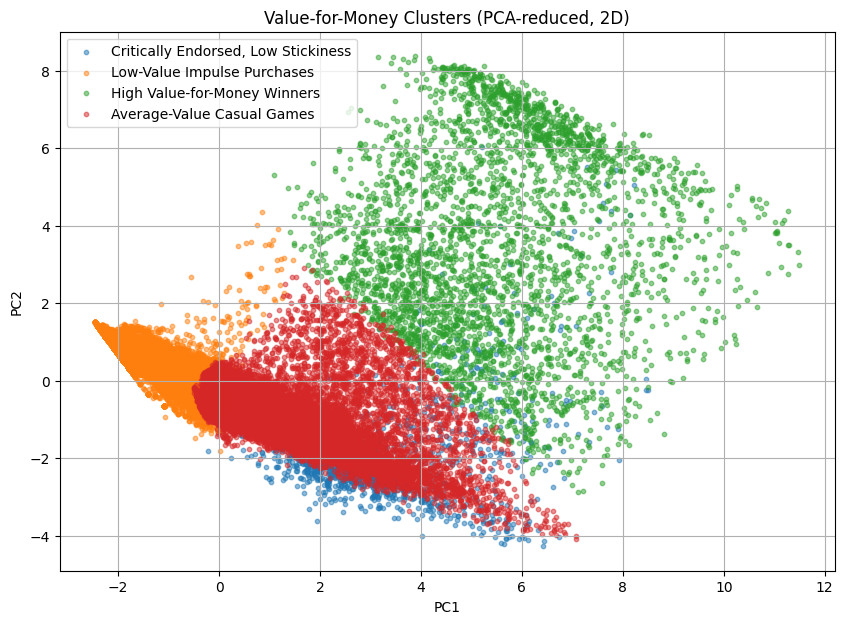

In [331]:
plt.figure(figsize=(10, 7))

for label in sorted(df_value2["value_cluster2"].unique()):
    idx = df_value2["value_cluster2"] == label
    plt.scatter(
        Xp_v2[idx, 0],
        Xp_v2[idx, 1],
        alpha=0.5,
        label=value_cluster_labels[label],
        s=10
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Value-for-Money Clusters (PCA-reduced, 2D)")
plt.legend()
plt.grid(True)
plt.show()

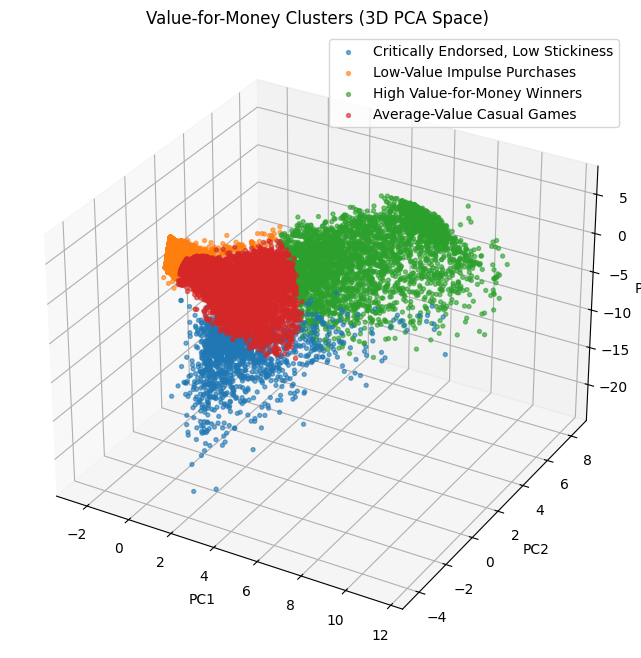

In [332]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

for label in sorted(df_value2["value_cluster2"].unique()):
    idx = df_value2["value_cluster2"] == label
    ax.scatter(
        Xp_v2[idx, 0],
        Xp_v2[idx, 1],
        Xp_v2[idx, 2],
        label=value_cluster_labels[label],
        s=8,
        alpha=0.6
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Value-for-Money Clusters (3D PCA Space)")
ax.legend()
plt.show()

In [342]:
cluster_summary = (
    df_value2
    .groupby("value_cluster2")
    .agg(
        games_count=("value_cluster2", "size"),  # <- THIS IS THE FIX
        price=("price", "median"),
        hours_per_price=("hours_per_price_raw", "median"),
        reviews_per_price=("reviews_per_price_raw", "median"),
        pos_ratio=("pos_ratio_counts", "median"),
        review_volume=("review_volume_log", "median"),
        dlc_count=("dlc_count", "median"),
        achievements=("achievements", "median"),
        metacritic=("metacritic_score_imp", "median"),
        meta_coverage=("meta_has", "mean")
    )
    .round(3)
)

cluster_summary

,games_count,price,hours_per_price,reviews_per_price,pos_ratio,review_volume,dlc_count,achievements,metacritic,meta_coverage
value_cluster2,,,,,,,,,,
0,1382,12.99,0.000,36.071,0.744,6.426,0.0,25.0,66.0,1.000
1,42498,4.99,0.000,0.000,0.500,1.609,0.0,0.0,75.0,0.000
2,3446,7.99,0.938,128.542,0.833,7.210,0.0,24.0,75.0,0.223
3,28132,7.99,0.000,8.697,0.833,4.454,0.0,18.0,75.0,0.043


In [343]:
cluster_descriptions = {
    0: "Critically Endorsed, Low Engagement",
    1: "Low-Value Impulse Purchases",
    2: "High Value-for-Money Games",
    3: "Moderate Value, Casual Games"
}

cluster_summary["description"] = cluster_summary.index.map(cluster_descriptions)
cluster_summary

,games_count,price,hours_per_price,reviews_per_price,pos_ratio,review_volume,dlc_count,achievements,metacritic,meta_coverage,description
value_cluster2,,,,,,,,,,,
0,1382,12.99,0.000,36.071,0.744,6.426,0.0,25.0,66.0,1.000,"Critically Endorsed, Low Engagement"
1,42498,4.99,0.000,0.000,0.500,1.609,0.0,0.0,75.0,0.000,Low-Value Impulse Purchases
2,3446,7.99,0.938,128.542,0.833,7.210,0.0,24.0,75.0,0.223,High Value-for-Money Games
3,28132,7.99,0.000,8.697,0.833,4.454,0.0,18.0,75.0,0.043,"Moderate Value, Casual Games"


##Value-for-Money Clustering: Key Findings

The value-for-money analysis identifies four distinct purchasing patterns among paid Steam games. These clusters reflect differences in engagement efficiency, review intensity, and player sentiment, rather than price alone.

###**Identified Clusters**
###Low-Value Impulse Purchases (Majority Cluster)
- Low playtime per peso
- Few reviews and weak engagement
- Often purchased but rarely played
- Represents the long-tail of the Steam market
###Average-Value Casual Games
- Moderate pricing and engagement
- Generally positive sentiment
- Played occasionally but not sustained over time
- Typical “buy, try, move on” titles
###High Value-for-Money Games
- Extremely high playtime relative to price
- Strong review activity and positive sentiment
- Indicates sustained player commitment
- Small but economically meaningful cluster
###Critically Endorsed, Low-Stickiness Games
- Higher prices and stronger critical or review signals
- Limited playtime efficiency
- Suggests that critical recognition does not always translate to long-term player value


##Overall Insight
Price alone is a weak indicator of value-for-money
Player behavior (playtime and reviews) is more predictive than cost or critical scores
True high-value games form a small but clearly separable segment within the dataset

Unlike engagement-based clustering, the value-for-money segmentation produced stable and interpretable groups driven by economic efficiency, social validation, and critical endorsement. PCA visualizations confirm clear separation across principal dimensions, validating the robustness of the clustering structure.